---
title: 03 - mouse analysis
author: Martin Proks
date: 26-08-2023
---

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import scvi
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import matplotlib.pyplot as plt

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read("../results/02_mouse_integration/scvi/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 2004 × 3000
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'batch_og', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_mde_scVI', 'X_scVI'
    layers: 'counts', 'scVI_normalized'

## 1. SCVI

In [4]:
USE_REP = 'X_scVI'

In [5]:
# Ideally find 15 clusters

sc.pp.neighbors(adata, use_rep=USE_REP)
sc.tl.leiden(adata, resolution=0.8)

2023-09-23 17:00:49.975107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


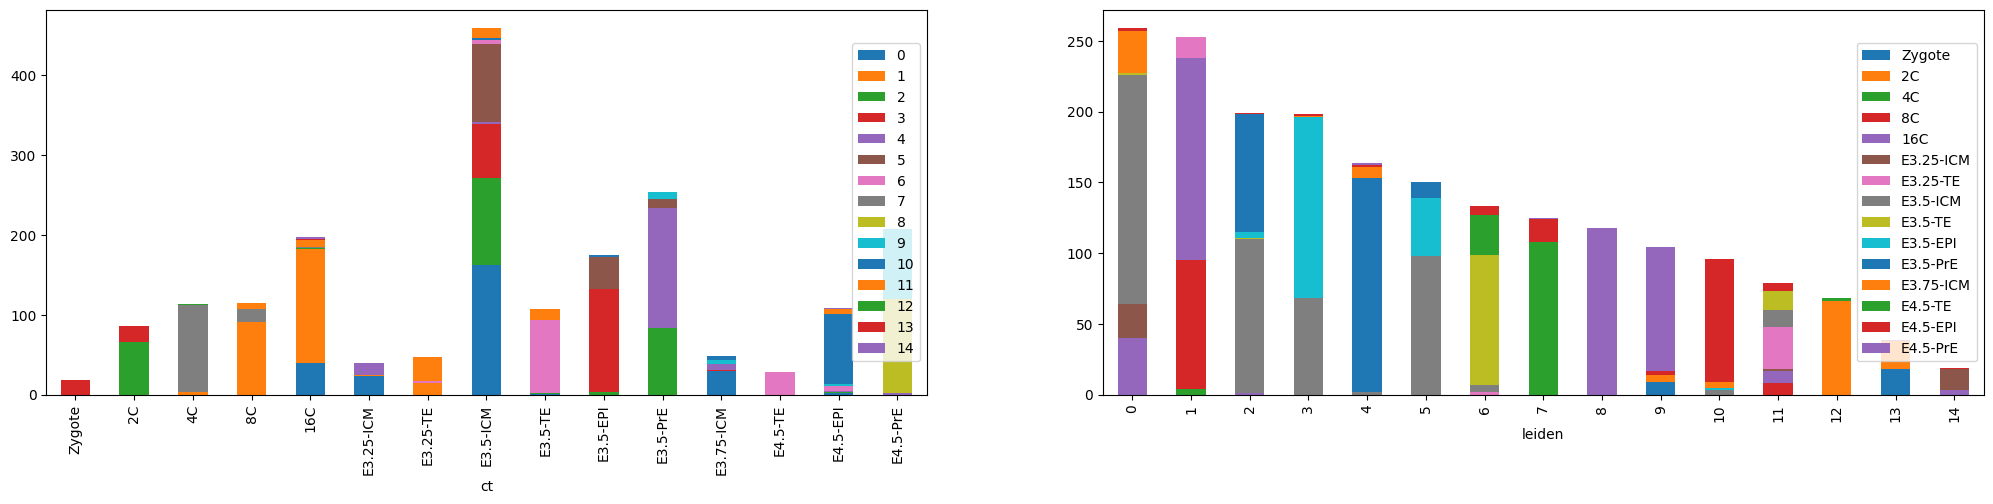

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[25, 5])
adata.obs.groupby(['ct', 'leiden']).size().unstack().plot(kind='bar', stacked=True, ax=ax[0]).legend(loc='right')
adata.obs.groupby(['leiden', 'ct']).size().unstack().plot(kind='bar', stacked=True, ax=ax[1]).legend(loc='right')

### 1.0. PCA

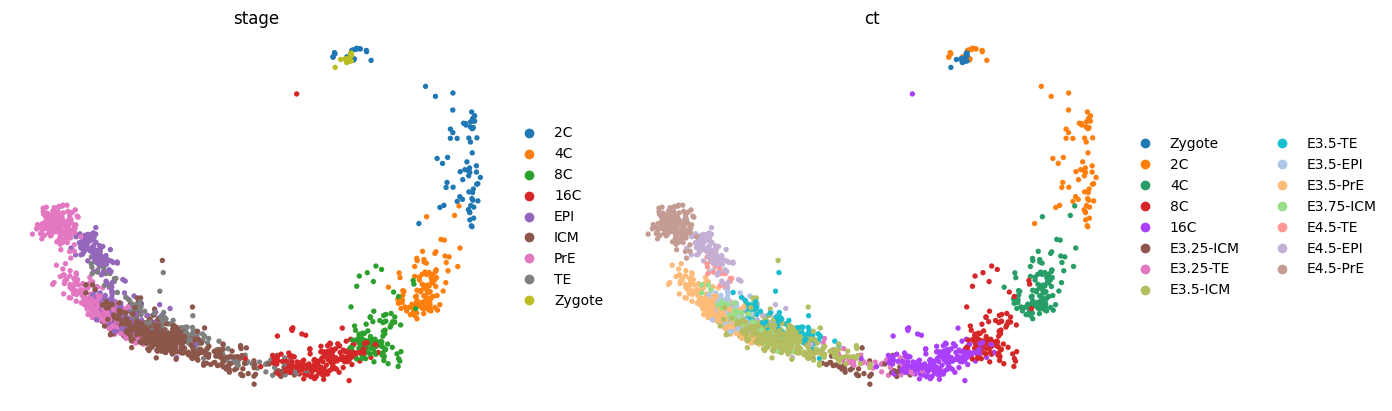

In [7]:
sc.tl.pca(adata)
sc.pl.pca(adata, color=['stage', 'ct'], frameon=False, ncols=2)

### 1.1. UMAP

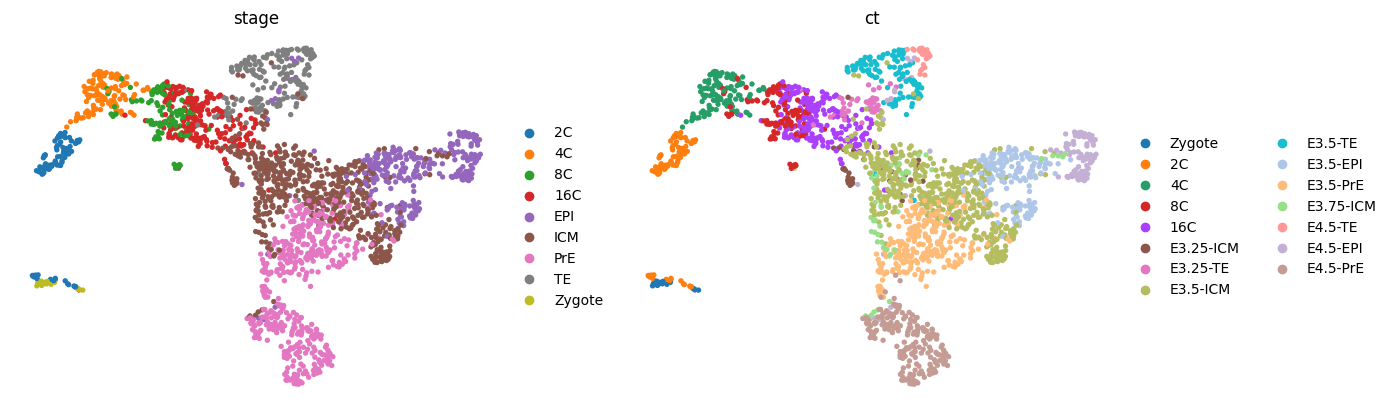

In [8]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['stage', 'ct'], frameon=False, ncols=2)

### 1.2. Phate

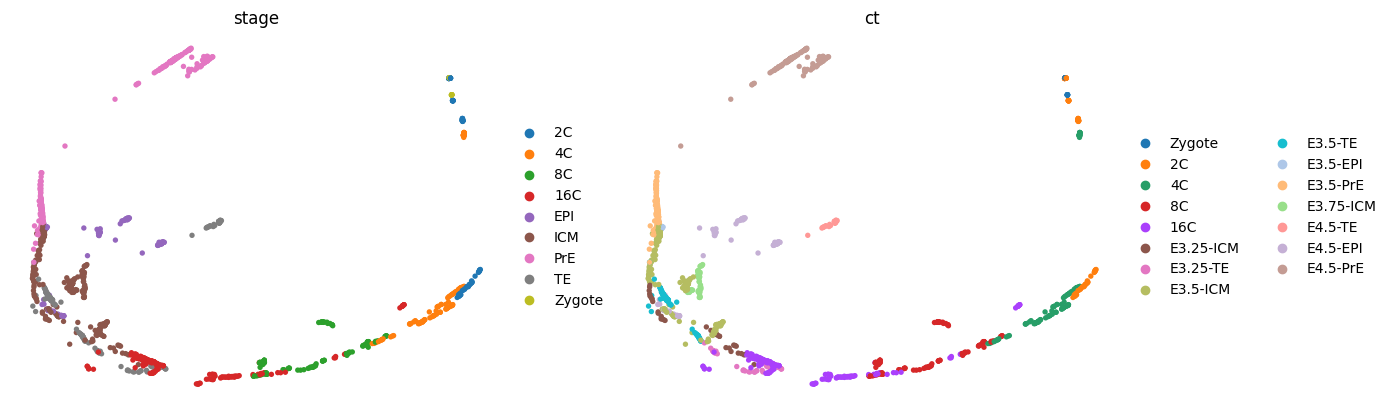

In [9]:
sce.tl.phate(adata, n_jobs=8)
sce.pl.phate(adata, color=['stage', 'ct'], frameon=False, ncols=2)

### 1.3. t-SNE

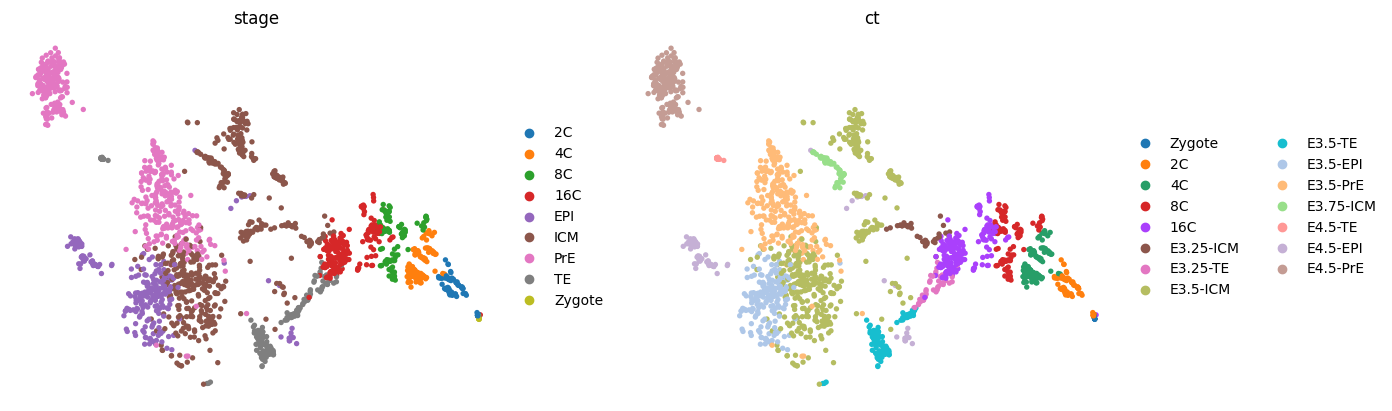

In [10]:
sc.tl.tsne(adata, n_jobs=8, perplexity=300)
sc.pl.tsne(adata, color=['stage', 'ct'], frameon=False, ncols=2)

### 1.4. Force Directed Graph

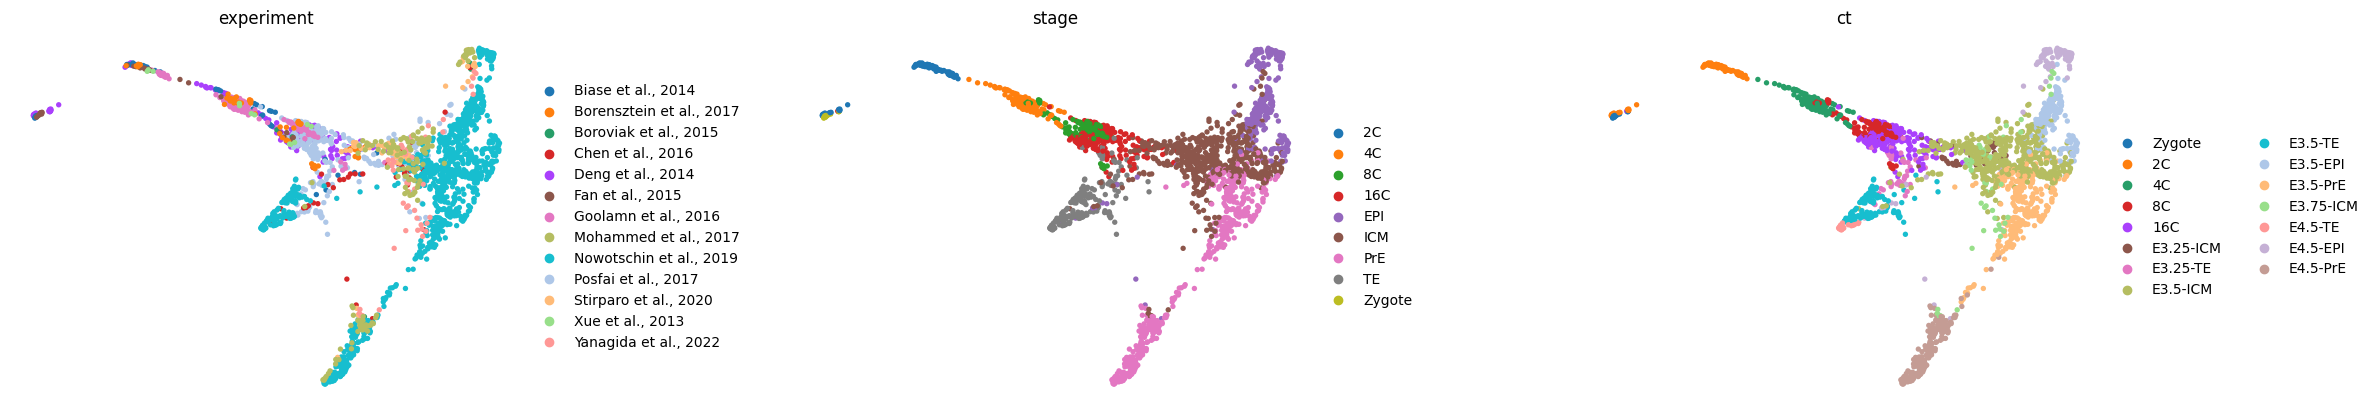

In [11]:
sc.tl.draw_graph(adata, n_jobs=8)
sc.pl.draw_graph(adata, color=['experiment', 'stage', 'ct'], frameon=False, ncols=3, wspace=0.4)

### 1.5. DC

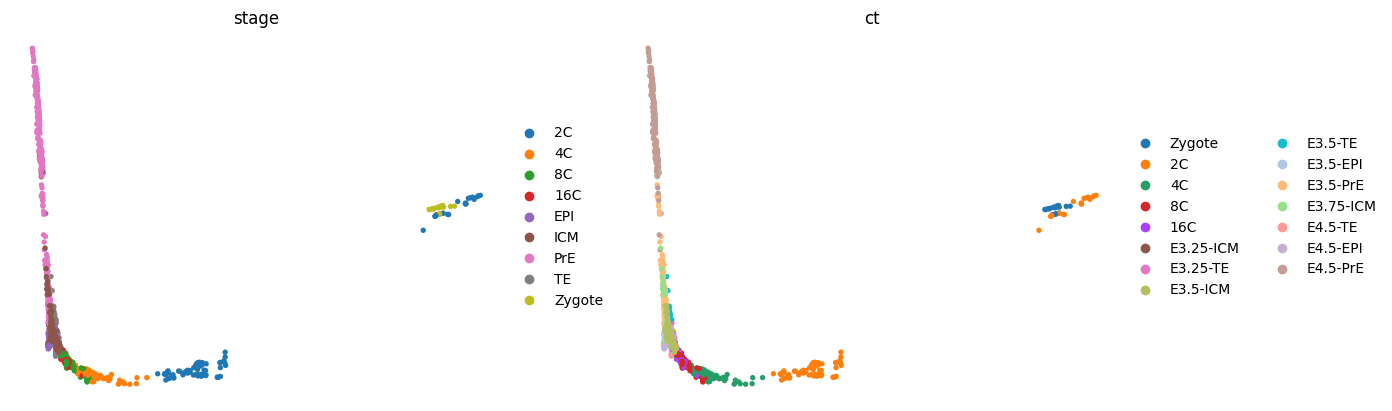

In [12]:
# Bug: https://github.com/scverse/scanpy/issues/2254
sc.tl.diffmap(adata)

adata.obsm["X_diffmap_"] = adata.obsm["X_diffmap"][:, 1:] 
sc.pl.embedding(adata, "diffmap_", color=['stage', 'ct'], frameon=False, ncols=2)

## 2. Pseudotime

In [13]:
adata

AnnData object with n_obs × n_vars = 2004 × 3000
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'batch_og', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'leiden', 'pca', 'stage_colors', 'ct_colors', 'umap', 'tsne', 'draw_graph', 'experiment_colors', 'diffmap_evals'
    obsm: 'X_mde_scVI', 'X_scVI', 'X_pca', 'X_umap', 'X_phate', 'X_tsne', 'X_draw_graph_fa', 'X_diffmap', 'X_diffmap_'
    varm: 'PCs'
    layers: 'counts', 'scVI_normalized'
    obsp: 'distances', 'connectivities'

### 2.1. DPT package

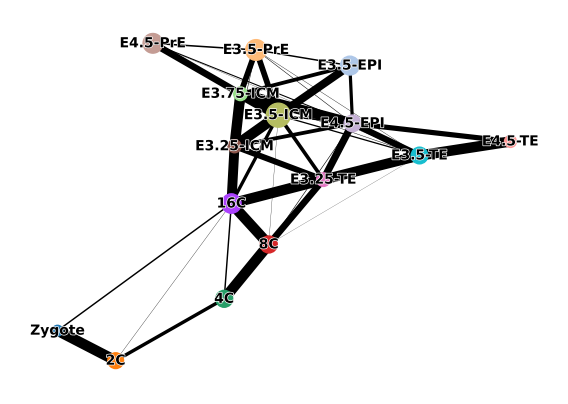

In [14]:
sc.pp.neighbors(adata, use_rep=USE_REP)
sc.tl.diffmap(adata)

sc.tl.paga(adata, groups='ct')
sc.pl.paga(adata, color=['ct'], frameon=False, fontoutline=True)
sc.tl.draw_graph(adata, init_pos='paga', n_jobs=10)

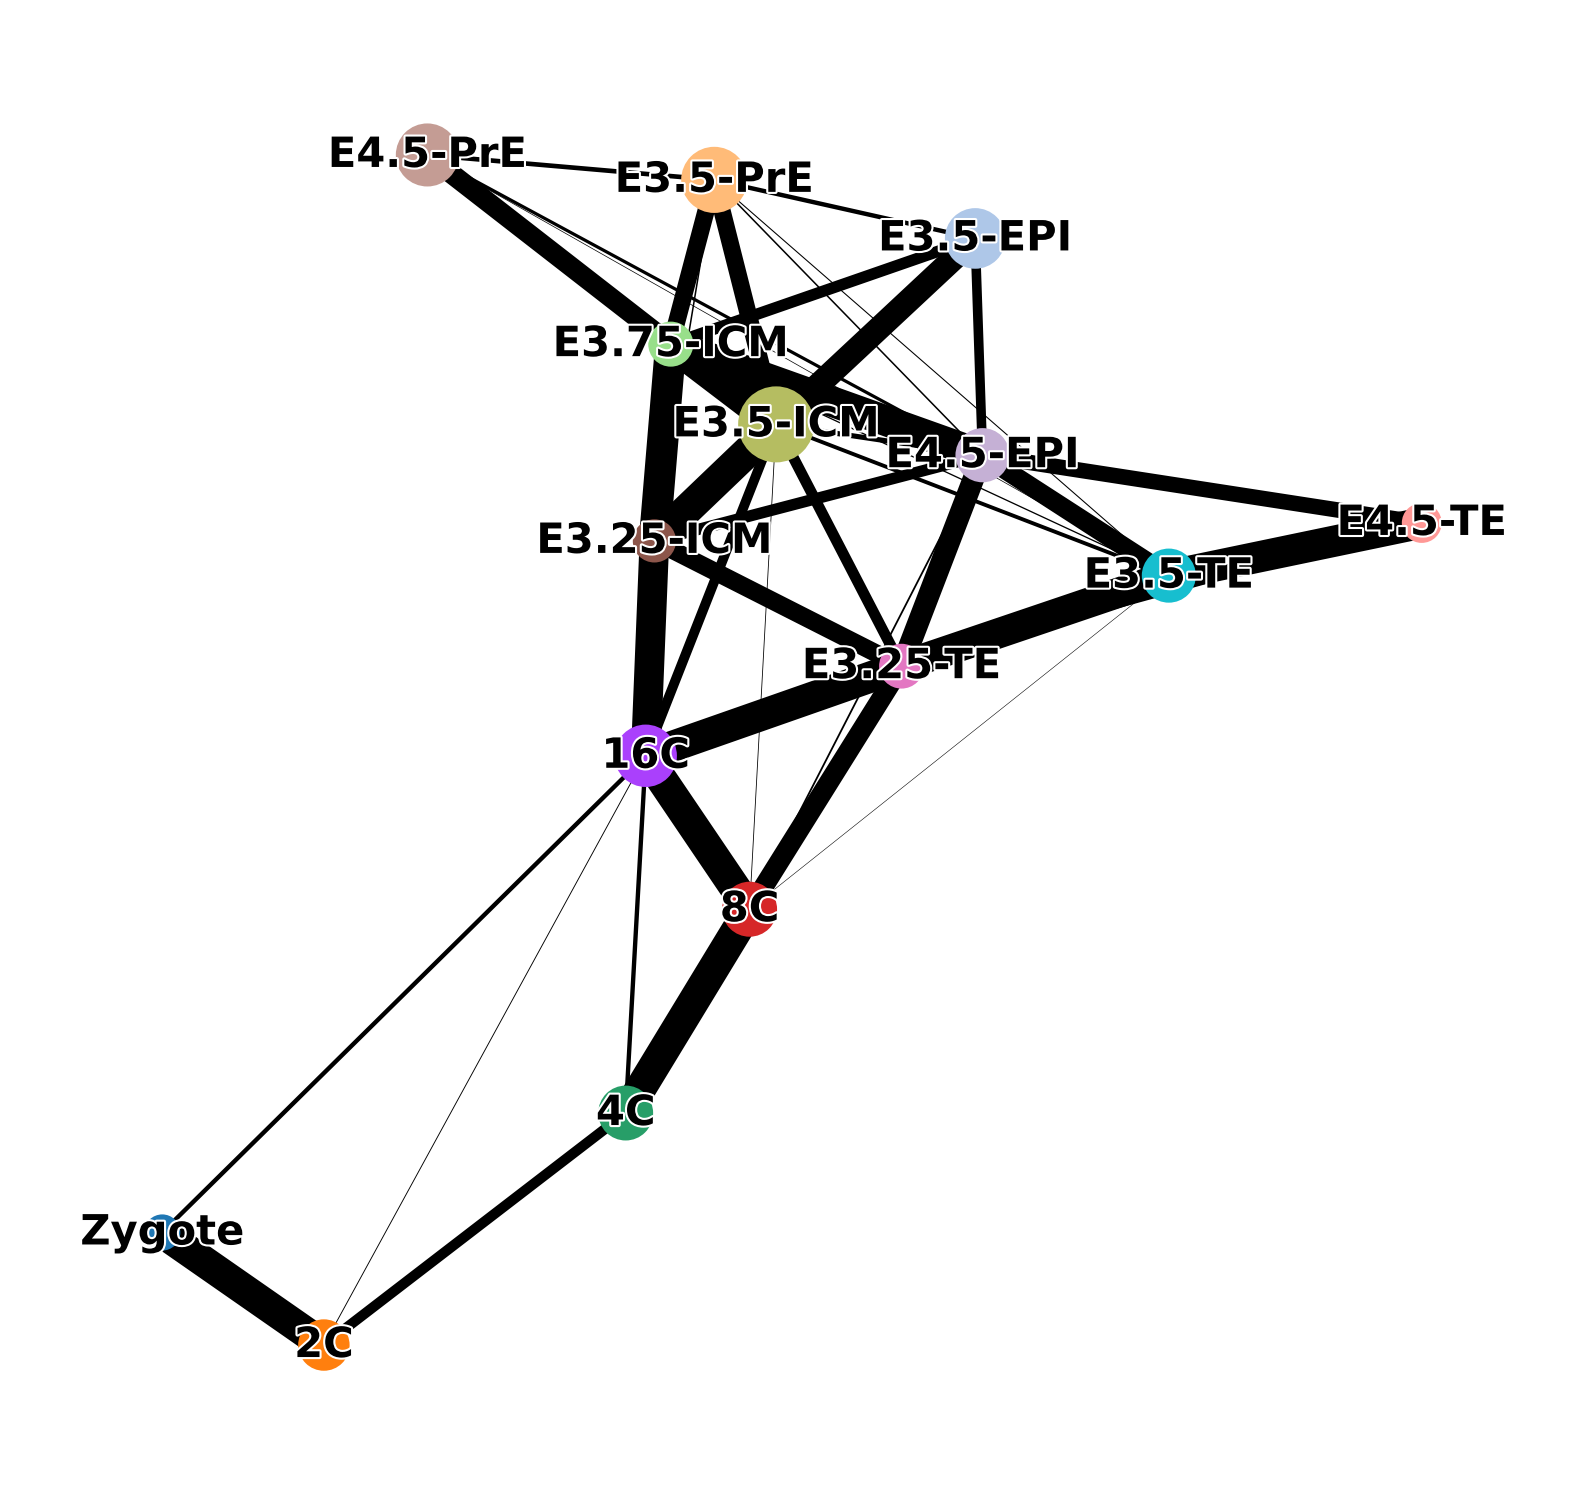

In [17]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": (300)}):
    sc.pl.paga(adata, color=['ct'], frameon=False, fontoutline=True)

In [18]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['ct']  == 'Zygote')[0]
sc.tl.dpt(adata)

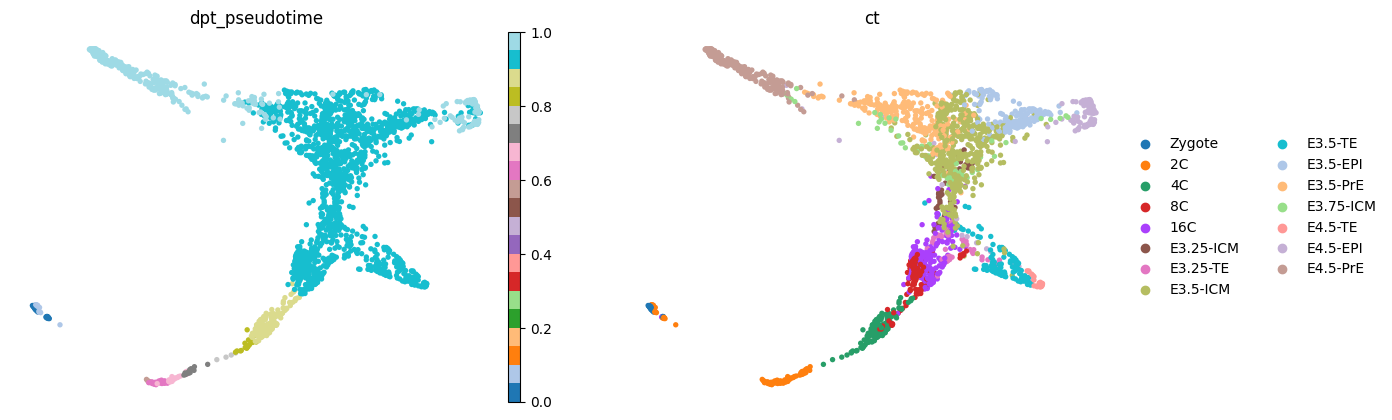

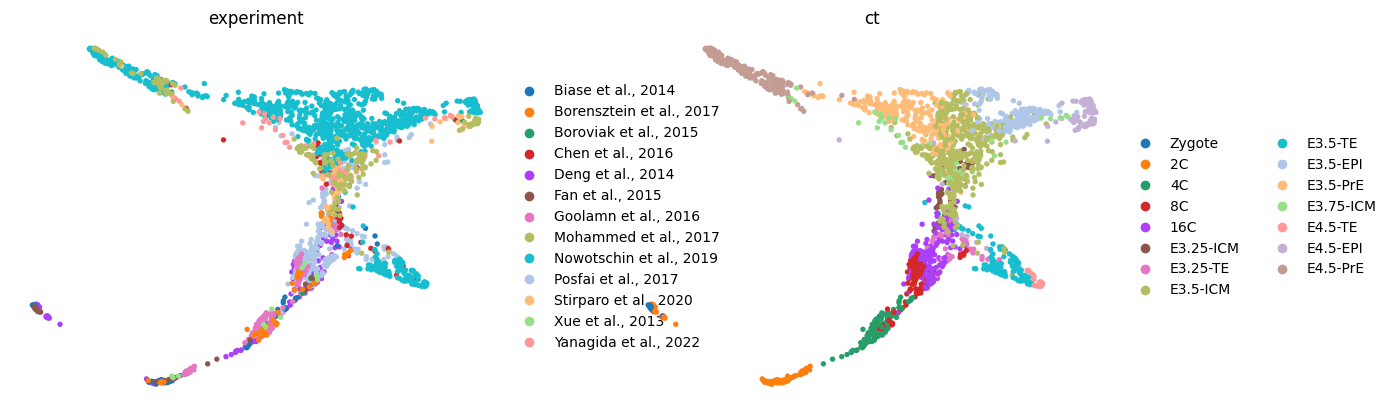

In [19]:
sc.pl.draw_graph(adata, color=['dpt_pseudotime', 'ct'], frameon=False, ncols=2, cmap='tab20')
sc.pl.draw_graph(adata, color=['experiment', 'ct'], frameon=False, ncols=2, cmap='tab20')

### 2.2. scFATEs

In [20]:
sc.pp.neighbors(adata, use_rep=USE_REP)
sc.tl.draw_graph(adata, n_jobs=10)

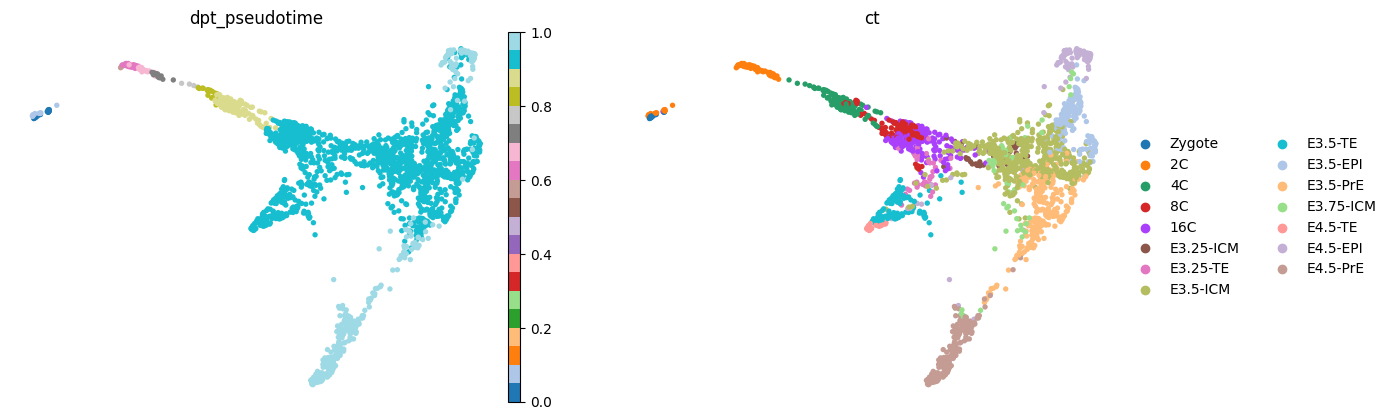

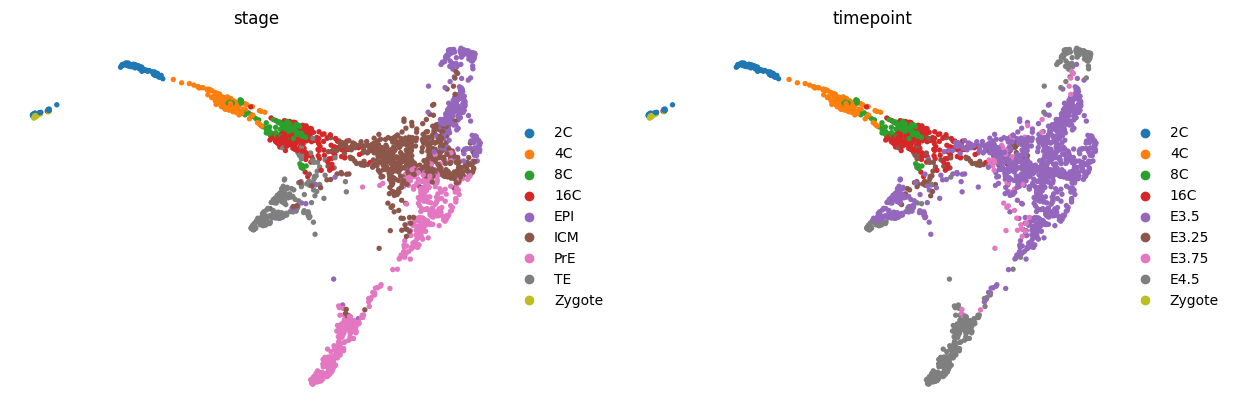

In [21]:
sc.pl.draw_graph(adata, color=['dpt_pseudotime', 'ct'], frameon=False, ncols=2, cmap='tab20')
sc.pl.draw_graph(adata, color=['stage', 'timepoint'], frameon=False, ncols=2, cmap='tab20')

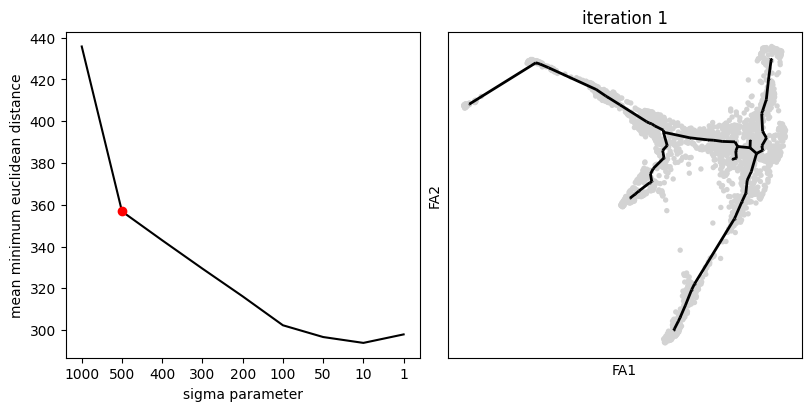

In [27]:
sig = scf.tl.explore_sigma(adata,
                         # Nodes=20,
                         Nodes=60,
                         use_rep="X_draw_graph_fa",
                         sigmas=[1000,500,400,300,200,100,50,10,1],
                         seed=42,plot=True)

In [28]:
scf.tl.tree(adata,
            # Nodes=30,
            Nodes=60,
            use_rep="X_draw_graph_fa",
            method="ppt",
            ppt_nsteps=10,
            ppt_sigma=sig,
            ppt_lambda=100,
            seed=42)

inferring a principal tree --> parameters used 
    60 principal points, sigma = 500, lambda = 100, metric = euclidean
    fitting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 265.16it/s]
    not converged (error: 0.019733842722593525)
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


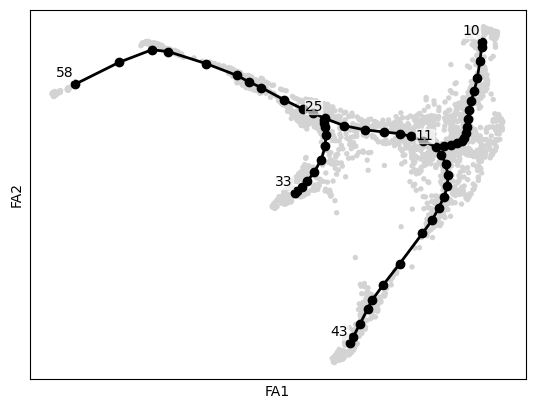

In [29]:
scf.pl.graph(adata)

In [35]:
scf.tl.root(adata, 58)

node 58 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [36]:
scf.tl.pseudotime(adata,n_jobs=10,n_map=10,seed=42)

projecting cells onto the principal graph
    mappings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]
    finished (0:00:22) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


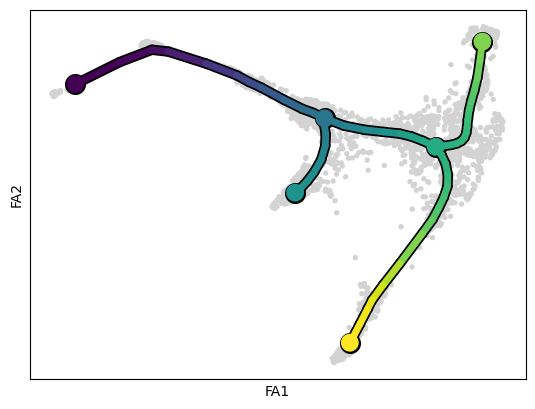

In [37]:
scf.pl.trajectory(adata)

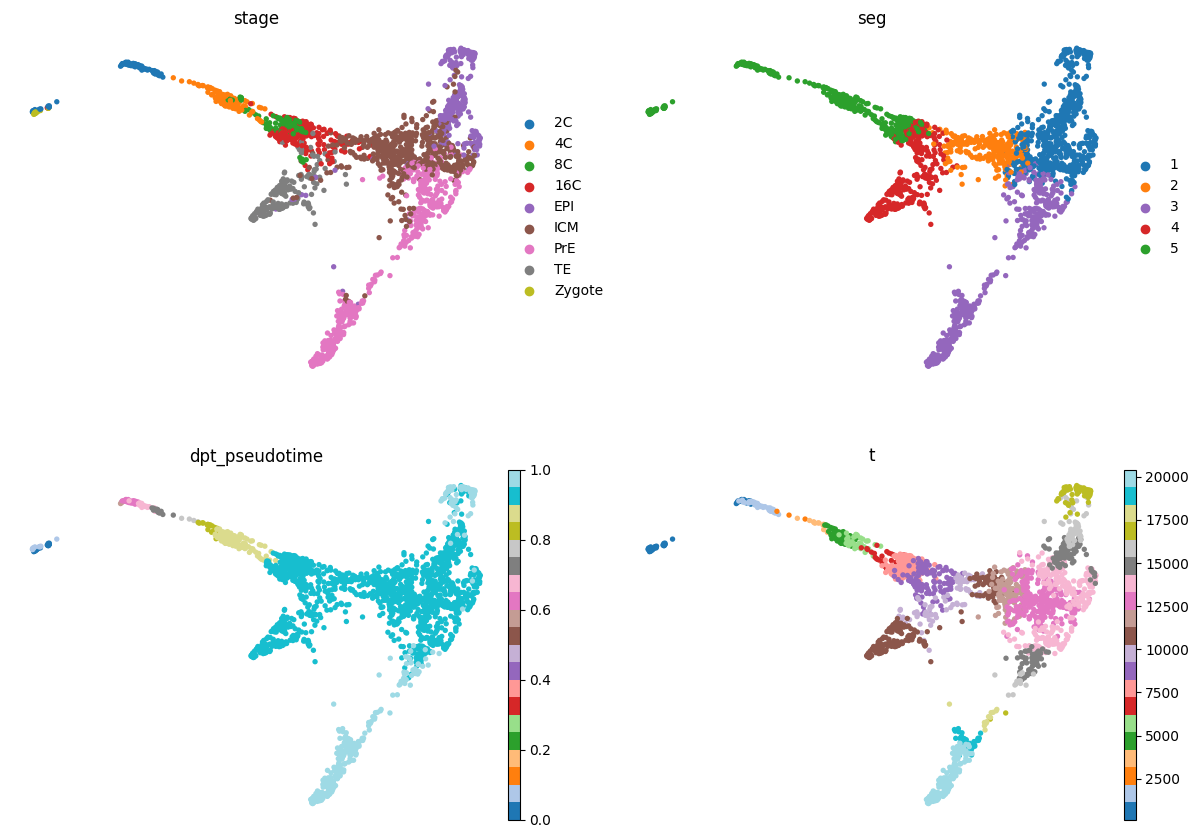

In [38]:
sc.pl.draw_graph(adata, color=['stage', 'seg', 'dpt_pseudotime', 't'], frameon=False, ncols=2, cmap='tab20')

Generating dendrogram of tree
    segment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]
    finished (0:00:02) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


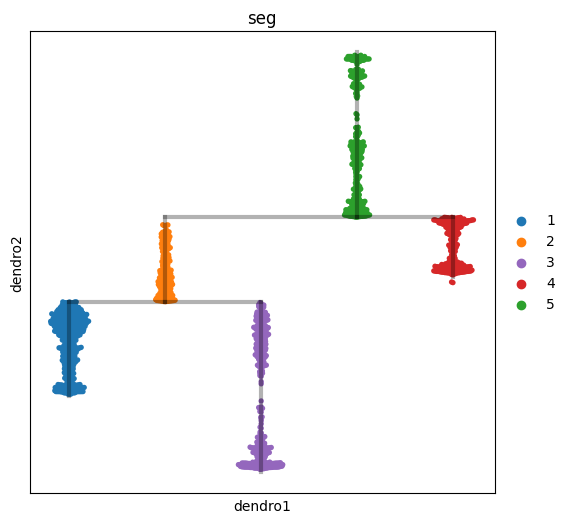

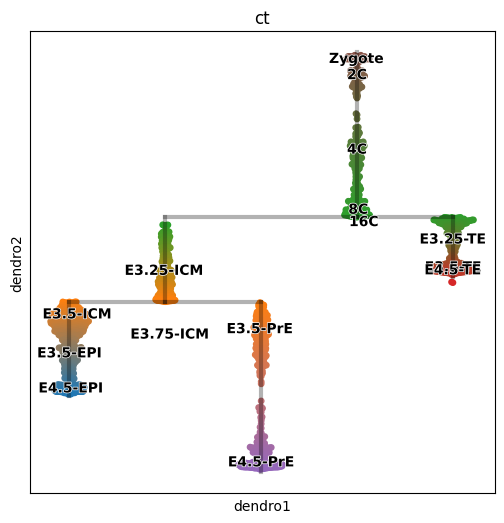

In [39]:
scf.tl.dendrogram(adata, n_jobs=8)
with plt.rc_context({"figure.figsize": (6, 6)}):
    scf.pl.dendrogram(adata,color="seg")
    scf.pl.dendrogram(adata,color="ct",legend_loc="on data",color_milestones=True,legend_fontoutline=True)

### 2.3. Palantir


**NOTE**: doesn't work, skipping

In [ ]:
# import logging
# logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

# sc.pp.neighbors(adata, use_rep="X_scANVI")
# sce.tl.palantir(adata, use_adjacency_matrix=True, distances_key="distances")
# sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=30)

# sc.pl.embedding(adata, basis='X_palantir_multiscale', color=['ct', 'stage'], frameon=False, ncols=2)

## 3. Differentially expressed genes

In [40]:
def filter_markers(df: pd.DataFrame, n_genes: int = 5, upper: bool = False):
    # significant only
    df = df[
        (df["is_de_fdr_0.05"])
        & (df["bayes_factor"] > 3)
        & (df["non_zeros_proportion1"] > 0.1)
        & (df["lfc_median"] > 0)
    ]
    comparisons = df.comparison.unique()

    deg_df = {}
    for comparison in comparisons:
        cluster = comparison.split(" ")[0]
        markers = (
            df.query("comparison == @comparison")
            .sort_values(by="lfc_median", ascending=False)
            .head(n_genes)
        )
        deg_df[cluster] = (
            markers.index.str.upper().tolist() if upper else markers.index.tolist()
        )

    return deg_df

In [41]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")

INFO     File ../results/02_mouse_integration/scvi/model.pt already downloaded                                     


In [42]:
m_ct = vae.differential_expression(groupby="ct")
m_ct_filt = filter_markers(m_ct, n_genes=10)

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.11s/it]


In [43]:
pd.DataFrame.from_dict(m_ct_filt, orient='index').transpose()

Zygote        2C             4C             8C            16C  \
0       aa545190      oog3          obox8          obox8  a430060f13rik   
1          oosp3  au016765         gm4850        gm21731        gm11544   
2       au016765     oosp3  b020004c17rik        gm11544           xkr9   
3           oog3    gm4850           oog3  a430060f13rik           dio1   
4          obox2     omt2a        gm36976  b020004c17rik        gm33508   
5         c87499  aa545190          omt2a       af067063        gm24289   
6  e330034g19rik    tcl1b5     d7ertd443e     d7ertd443e         gm5435   
7        gm43269    tcl1b4        gm21731        gm13339        gm12446   
8         tcl1b4    c87499          gdap1          dynap          dynap   
9          oosp2     oosp2           spz1           xkr9       snord35a   

  E3.25-ICM  E3.25-TE       E3.5-ICM    E3.5-TE E3.5-EPI  E3.5-PrE  \
0   gm24289     gata3  1700021a07rik    tmprss2   fbxw10   gm19510   
1   gm24920   gm24920         dglucy       adh1   nkain4     foxa2   
2   gm24616   gm24289          gm807    slc15a2   lefty2    lefty2   
3      xkr9    gm5907        aldh3a1       epn3      mal     sox17   
4   gm25328   tmprss2         nkx6-2       cdx2  gm26564      dkk1   
5  snord35a     cryab          crygd      gata3     cobl     bmper   
6       cck    gm6334           sox2      dppa1     cd3g      lmo2   
7   gm25636  au021092            mal        id2    myh13       f2r   
8      dio1      arg2           lmo2      cryab  gm12688  serpinh1   
9   gm33508      nat8         gm5662  serpinb6b    gm807     flrt3   

       E3.75-ICM  E4.5-TE       E4.5-EPI E4.5-PrE  
0        rnase12   s100a9          calca     has2  
1          iglv2     fasl        nphs1os    clic5  
2           nnmt    cald1        gm12690   spink1  
3  c330004p14rik    rhox6          stmn2    clic6  
4        gm30717      h19        col18a1    habp2  
5         gm6284     elf5          fgf15     tfec  
6           gpx8     hpgd        gm26564    rhox6  
7        gm13339   ankrd1           ctsw      ttr  
8           p3h2  slc16a3         prss50   chst15  
9          stfa1  tmprss2  c330004p14rik     p3h2

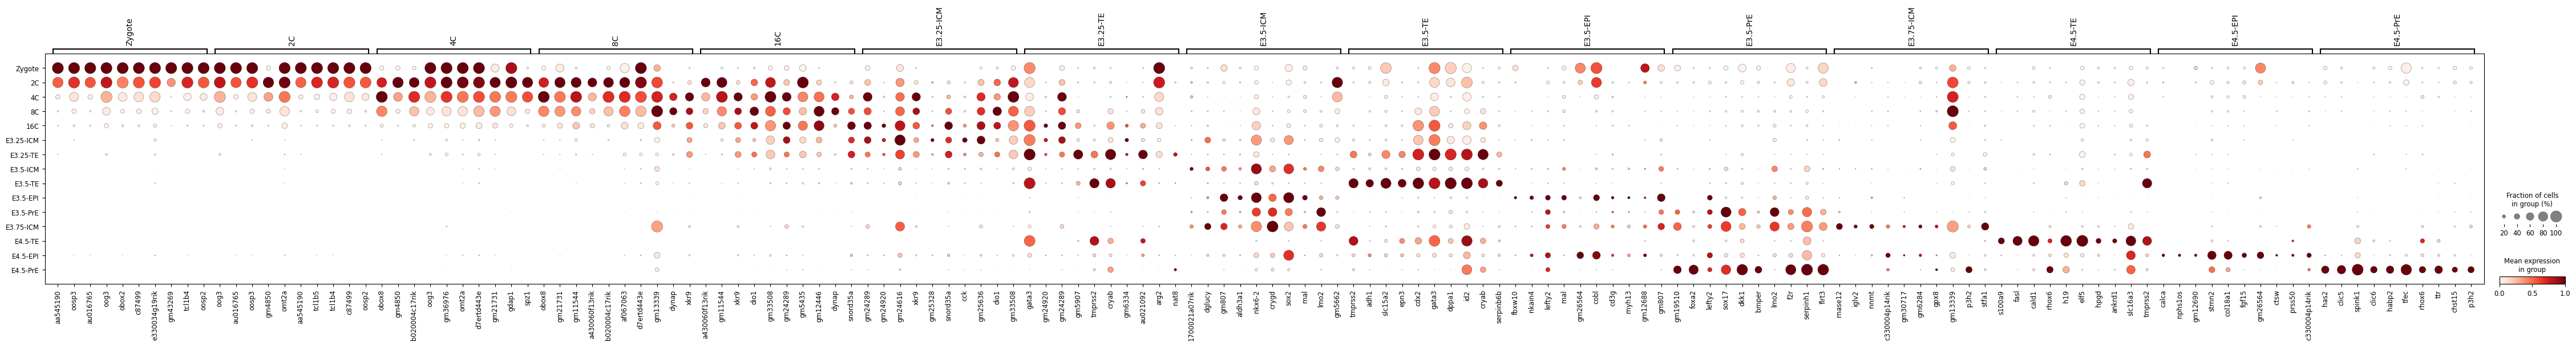

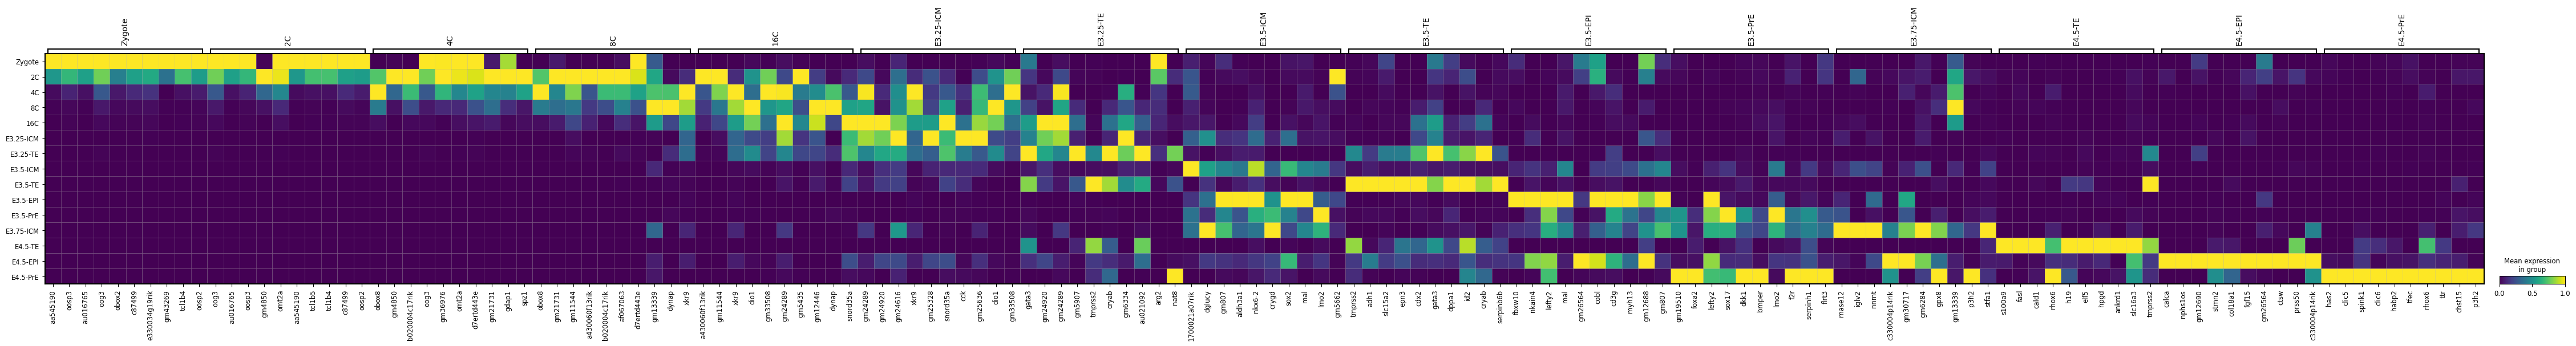

In [44]:
sc.pl.dotplot(adata, m_ct_filt, groupby='ct', dendrogram=False, standard_scale='var')
sc.pl.matrixplot(adata, m_ct_filt, groupby='ct', dendrogram=False, standard_scale='var')

### 4. Markers

- zygote/2C: zscan4a, zscan4b, zscan4c, zscan4d, zscan4f
- 8c: carm1, cdx2, pard3, pard6, apkc
- totipotency: cdx2, gata6, nanog
- apical domain: apkc, par2, par6, ezrin
- basolateral domain: cdh1, lgl, par1
- TE: cdx2, nanog, gata6
- inner cell mass: pou5f1, nanog, gata6, sox2, lats, klf4, dppa3, esrrb
- primitive endoderm: pou5f1, gata6, gata4, dab2, sox7, sox17, pdgfra, hnf4a
- epiblast: pou5f1, nanog, sox2, fgf4, pecam, fgf5, bmp4, klf2

---

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1994725/
- https://link.springer.com/article/10.1007/s00441-021-03530-8
- https://journals.biologists.com/dev/article/143/7/1063/47817/Lineage-specification-in-the-mouse-preimplantation

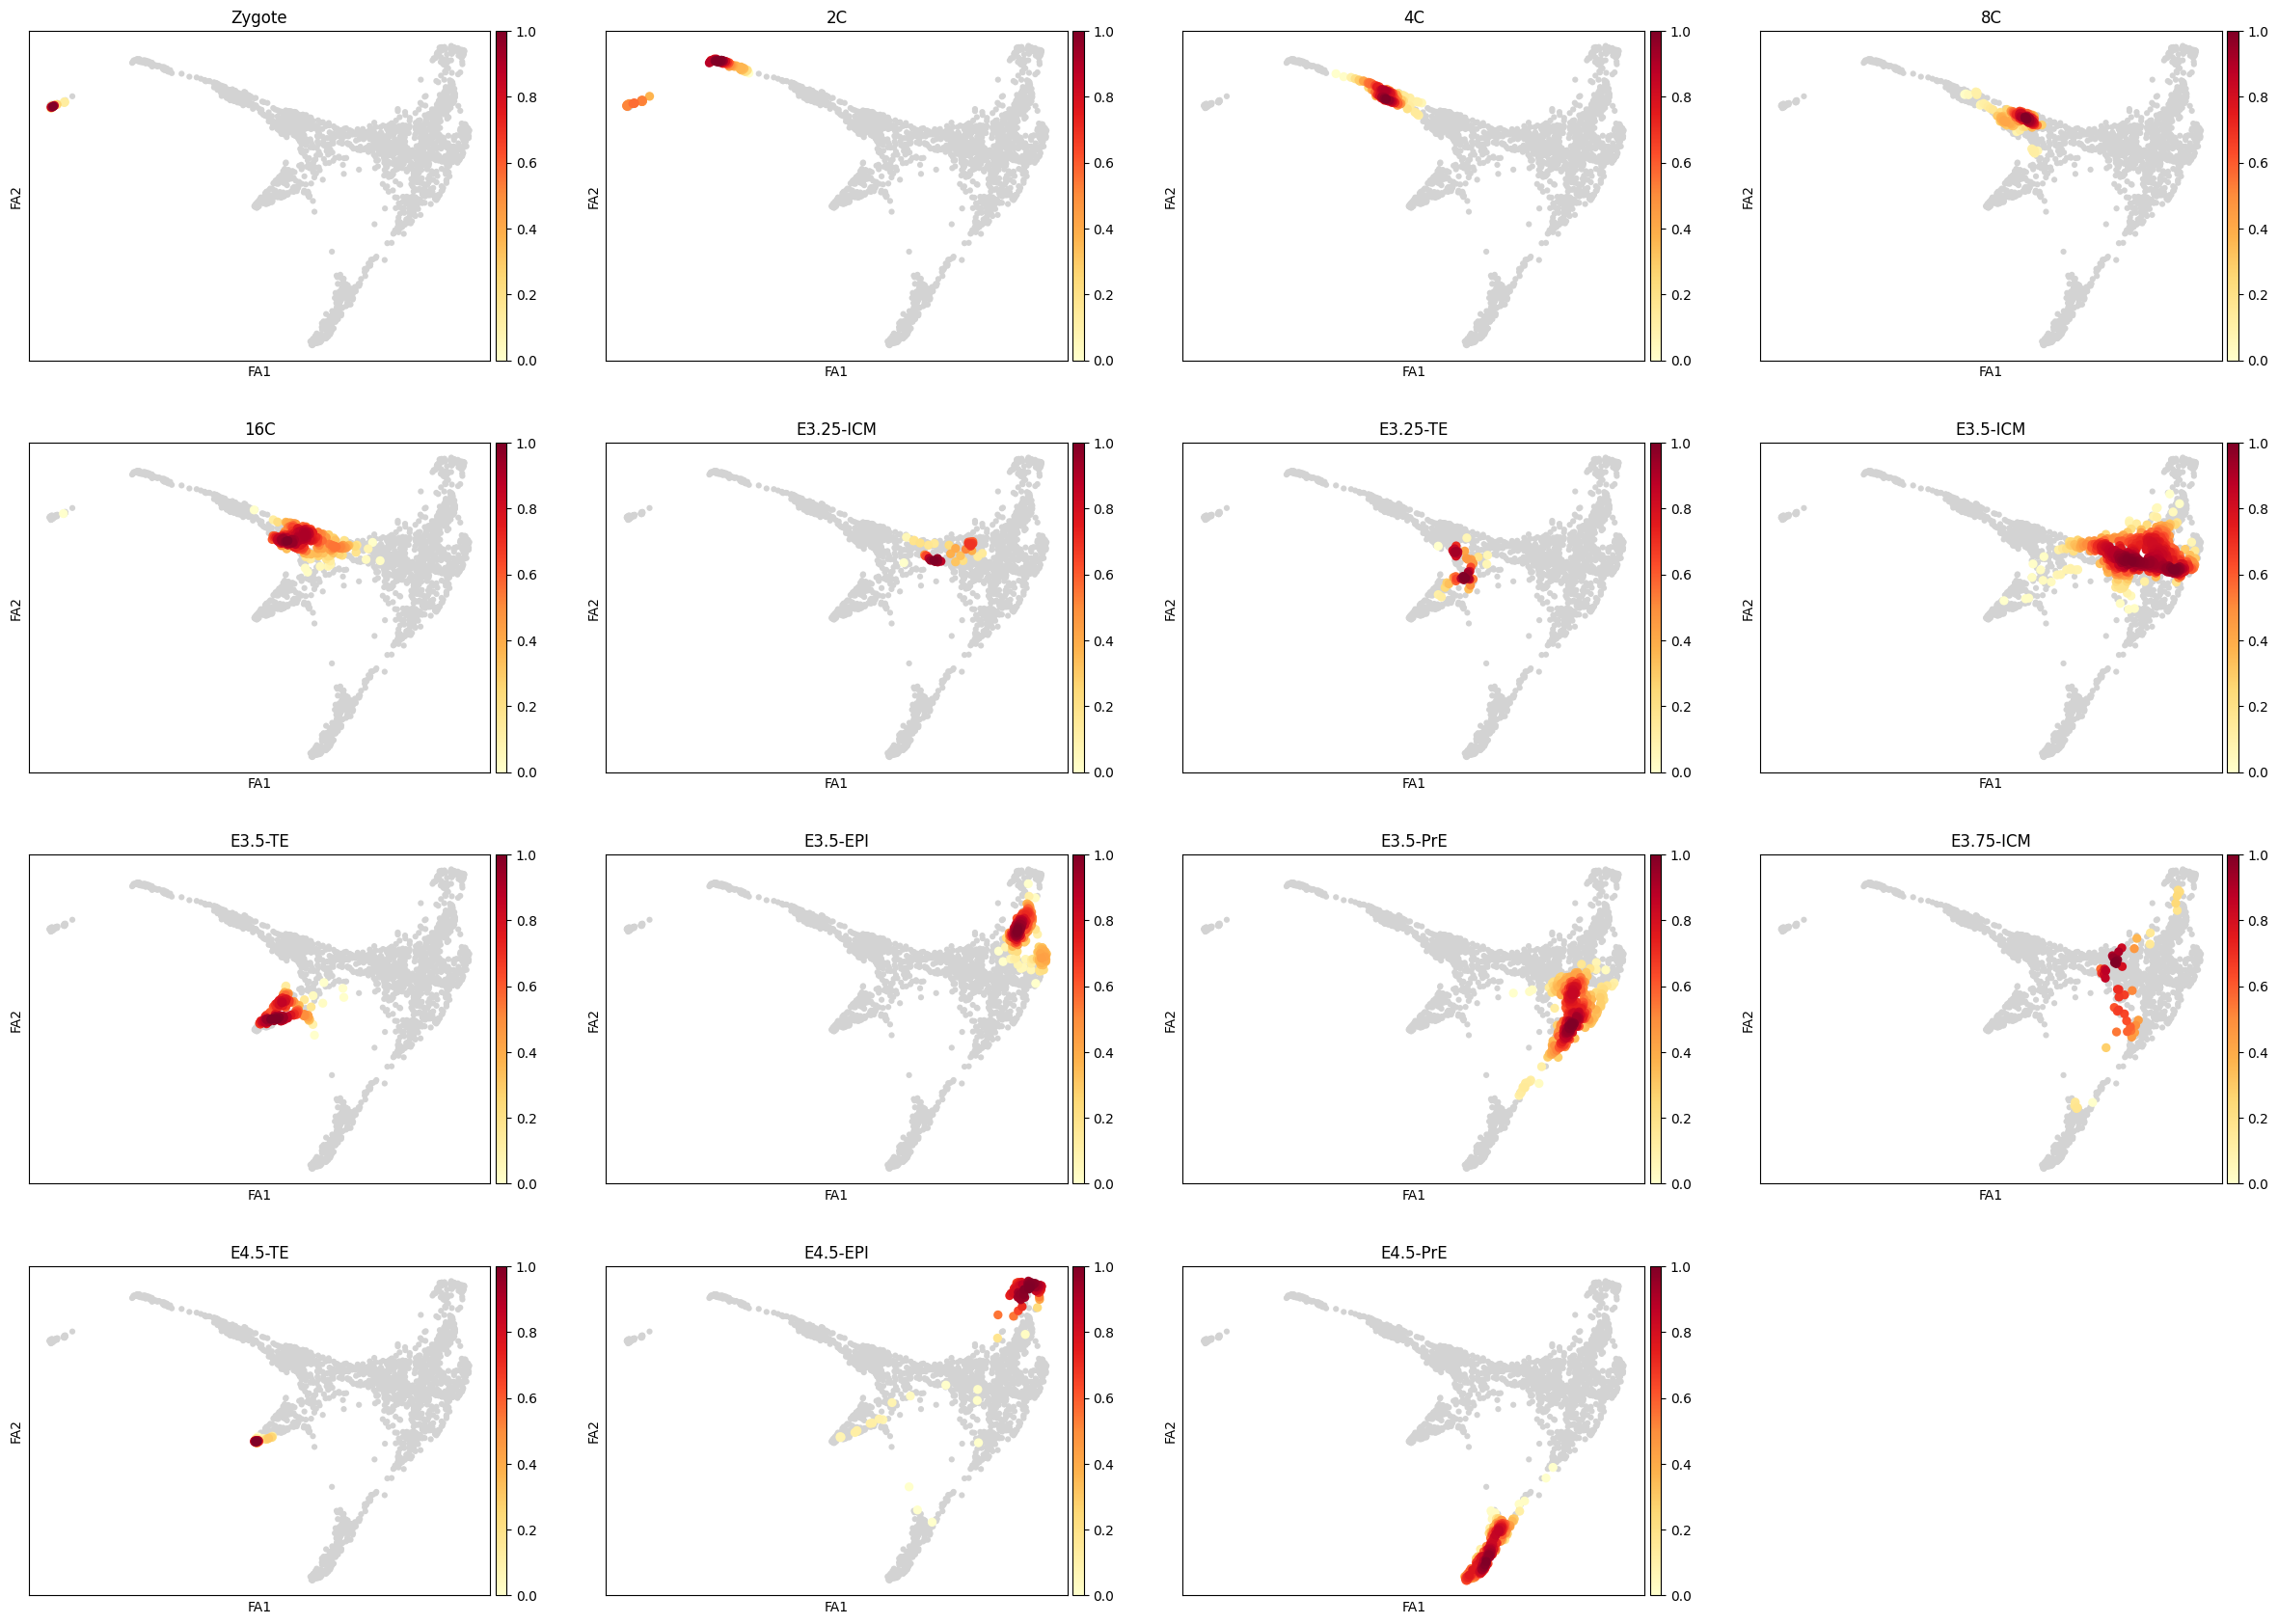

In [45]:
sc.tl.embedding_density(adata, basis='draw_graph_fa', groupby='ct')
sc.pl.embedding_density(adata, basis='draw_graph_fa', key='draw_graph_fa_density_ct')

In [46]:
lineage_markers = pd.read_excel("../data/external/mouse_lineage_markers.xlsx", sheet_name="Sheet1").fillna('')
lineage_markers

Zygote        2C     4C      8C     16C      TE      ICM     PrE     EPI
0   Zswim3   Zscan4a  Sin3a  Pou5f1  Pou5f1    Cdx2   Pou5f1   Gata6  Pou5f1
1   Trim28   Zscan4b  Clock   Nanog   Nanog   Gata3    Gata6   Gata4   Nanog
2    Padi6   Zscan4c  Sox21    Sox2    Sox2   Gata2    Nanog    Sox7    Sox2
3            Zscan4d  Carm1    Cdx2    Cdx2   Eomes  Tfcp2l1   Sox17    Fgf4
4            Zscan4f           Yap1   Esrrb   Lats2    Dppa3  Pdgfra    Klf2
5             Zfp352          Eifg1  Prdm14  Tfap2c    Esrrb    Dab2        
6            Usp17ld         Prdm14  Tfap2c           Prdm14                
7               Rxra                  Gata3                                 
8             Tmem92                  Gata2                                 
9           Pramef25                                                        
10               Dux

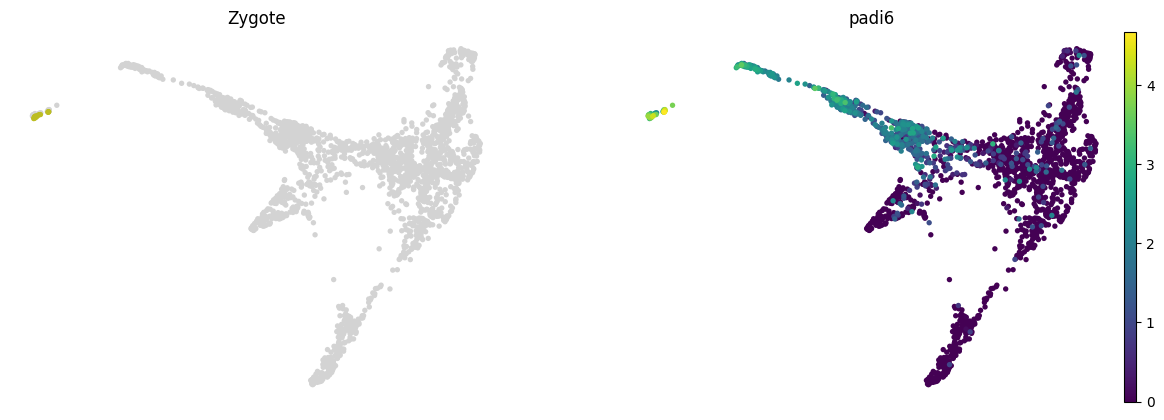

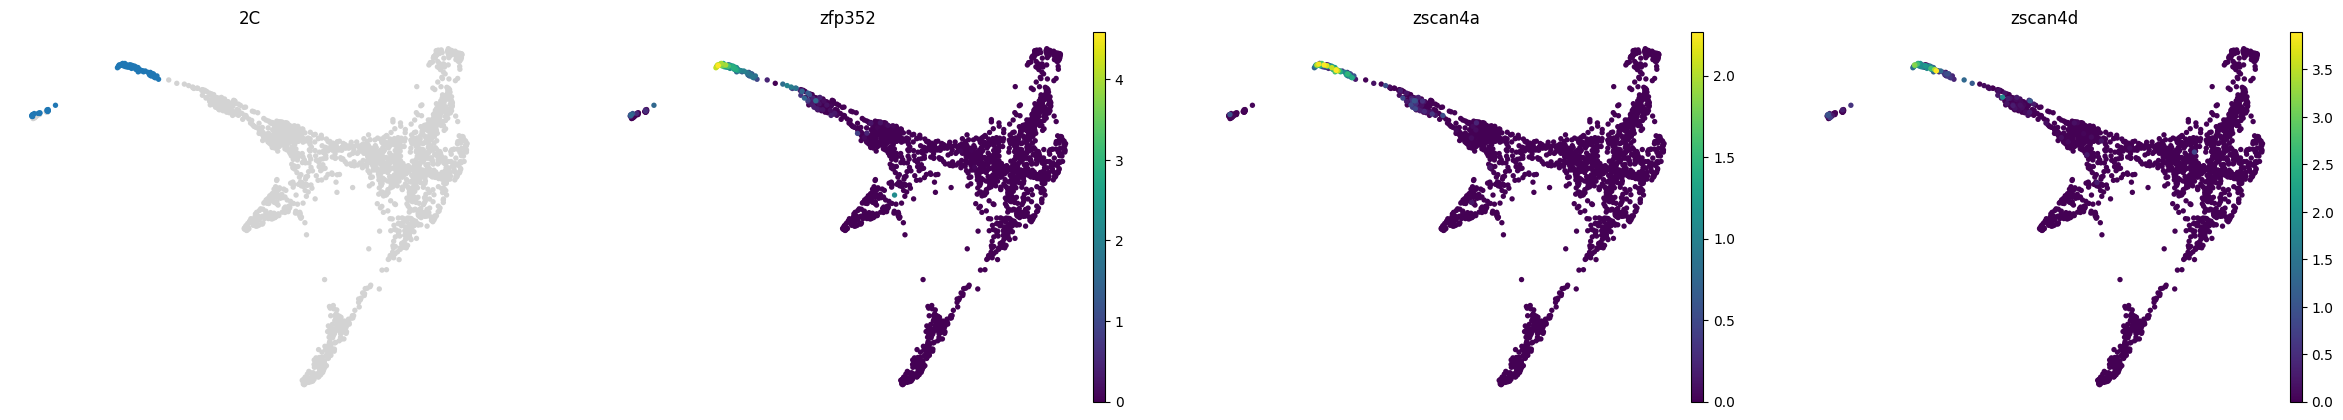

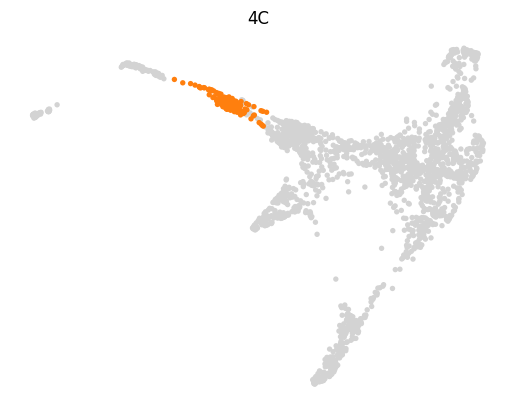

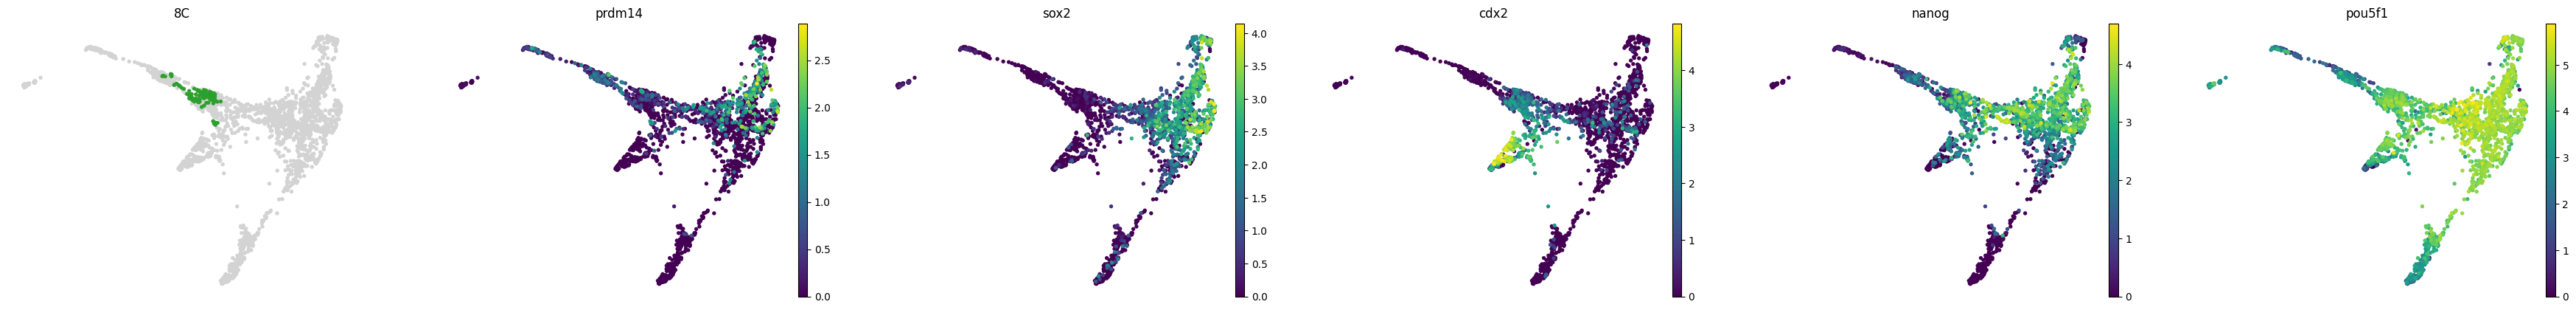

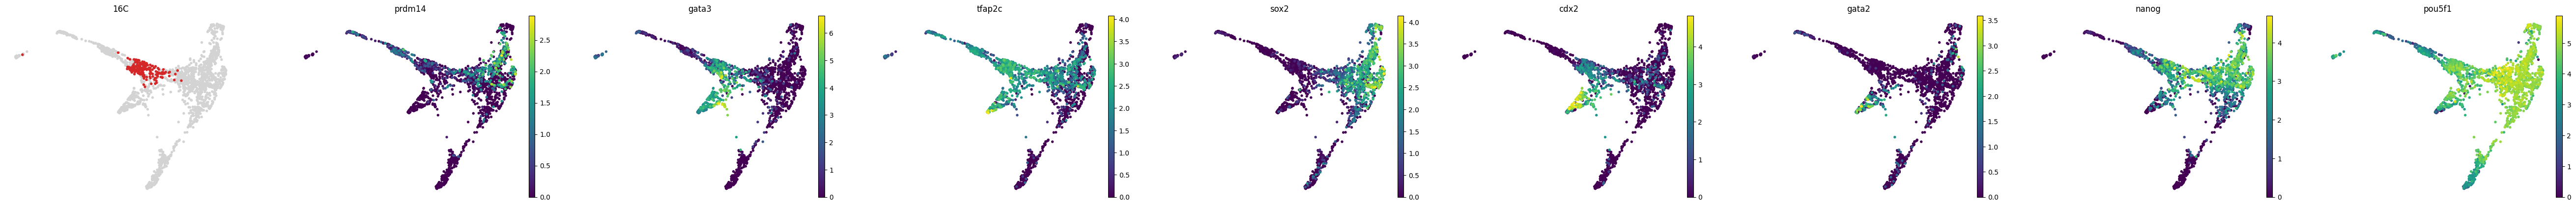

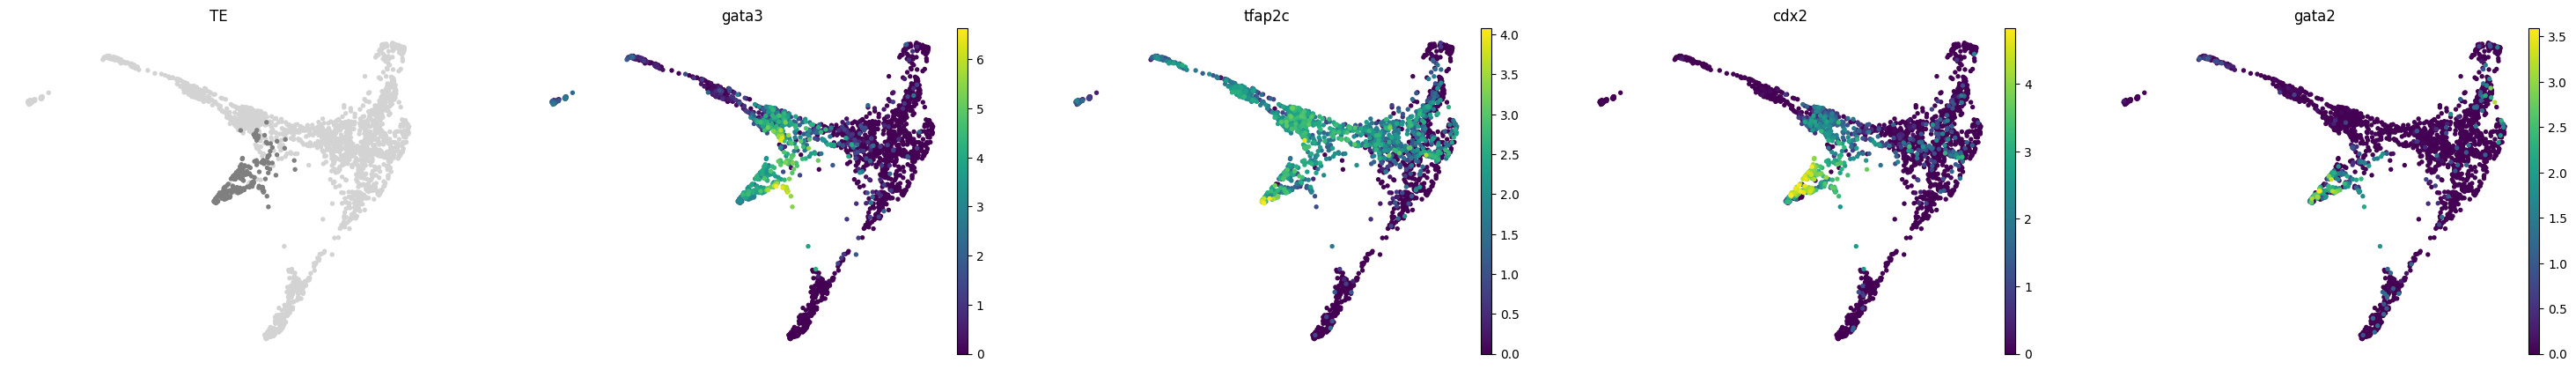

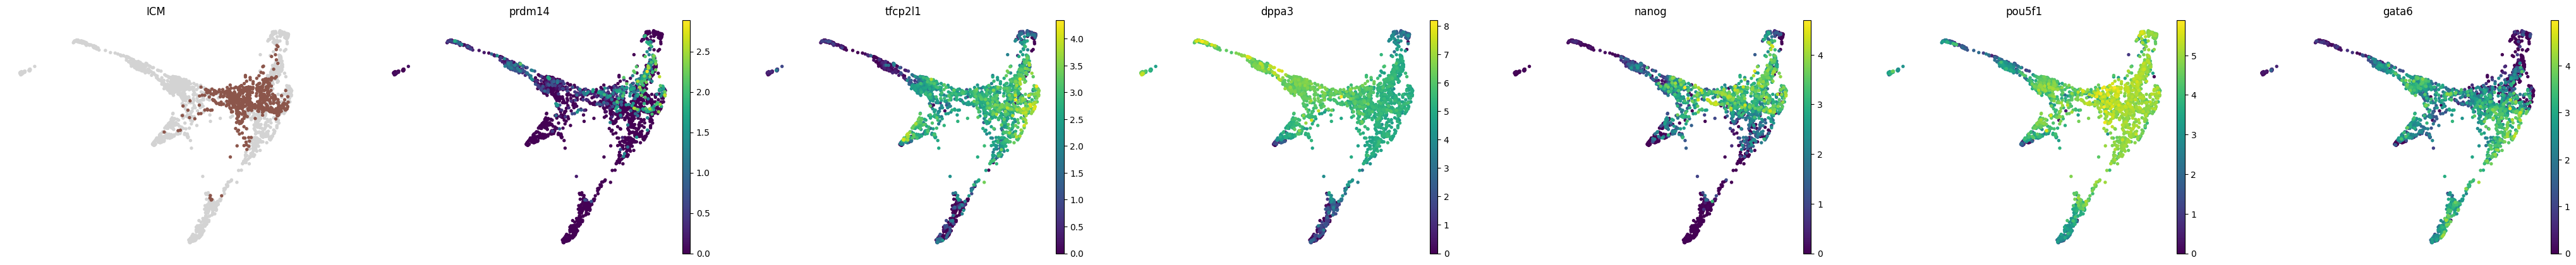

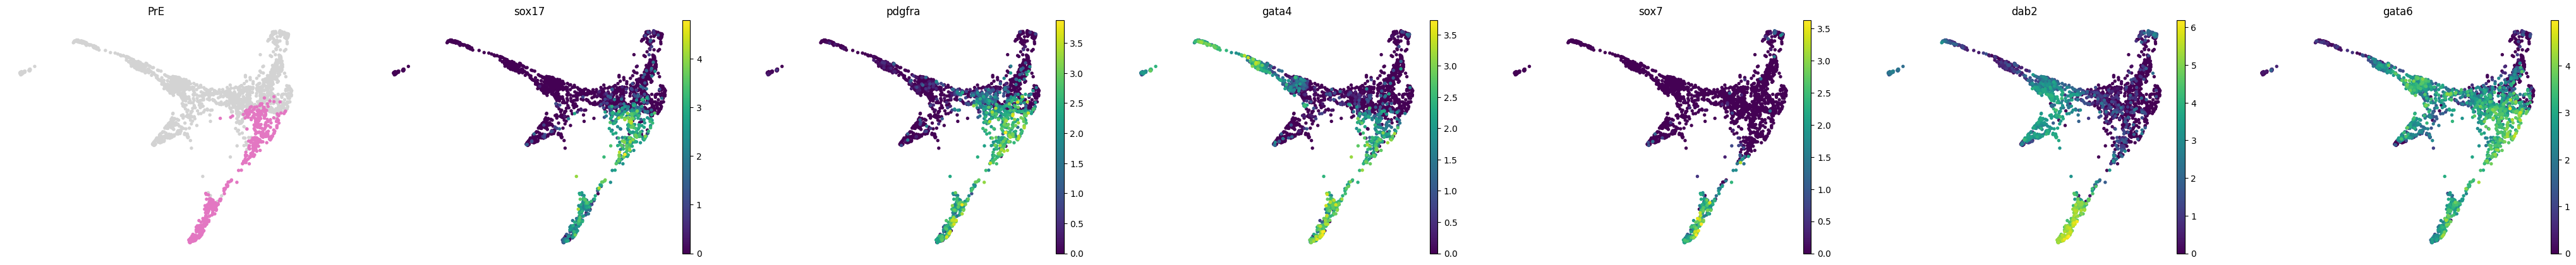

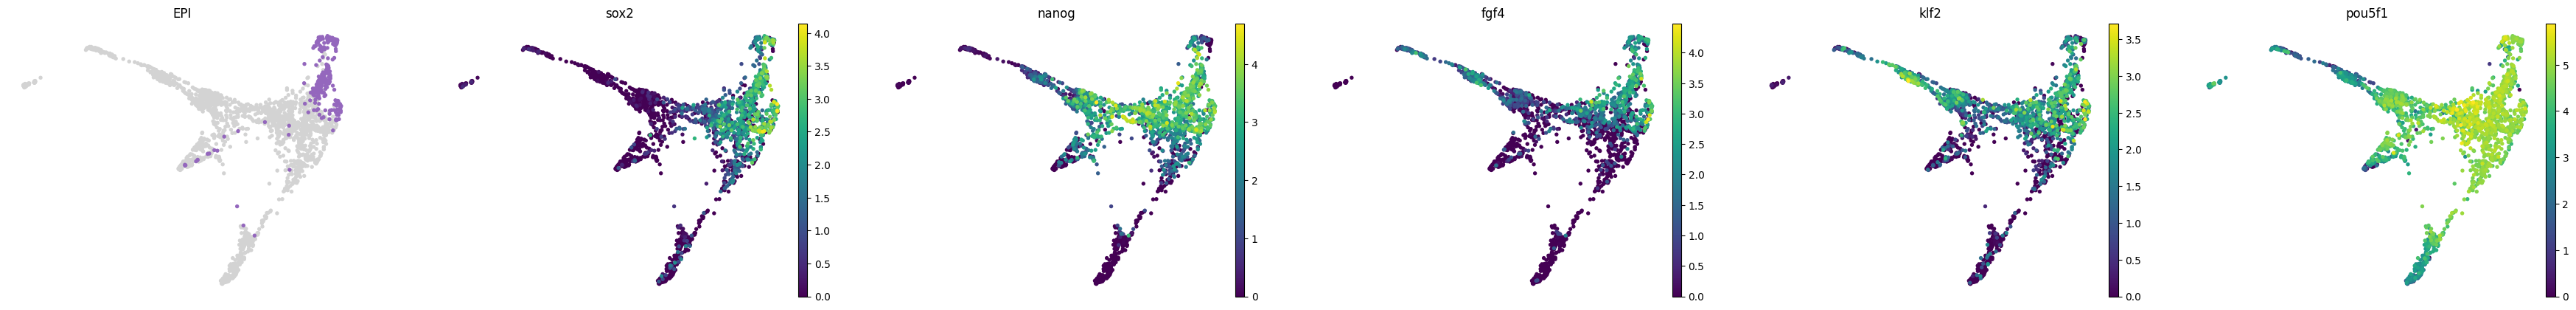

In [47]:
for stage, genes in lineage_markers.to_dict('list').items():
    common_genes = adata.var_names.intersection([str.lower(g) for g in genes if g != ''])
    
    # print(stage, common_genes)
    sc.pl.draw_graph(adata, color=['stage', *common_genes], title=[stage, *common_genes],
                     groups=stage, legend_loc=None, frameon=False, ncols=len(common_genes) + 1)

## Save model

In [48]:
adata.write("../results/03_mouse.processed.h5ad")

## 4. OTHER

### 2. scGEN

`scGen` returns imputed counts only. In this case we are not able to run DEGs because we need to have normalized counts.
The `predict` function also won't work because we don't have any perturbation in the dataset.

In [ ]:
import scgen

In [ ]:
mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")

In [ ]:
corrected_adata = mscgen.batch_removal()
corrected_adata

In [ ]:
sc.pp.neighbors(corrected_adata, use_rep='corrected_latent')
sc.tl.draw_graph(corrected_adata)

In [ ]:
sc.pl.draw_graph(corrected_adata, color=['ct', 'Stage'], wspace=0.4, frameon=False)

In [ ]:
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['batch', 'Stage'], wspace=0.4, frameon=False)

### 3. Integration stats

In [ ]:
from rich import print
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="ct",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI", "X_scgen"],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
from pysankey import sankey


%run ../scripts/helpers.py

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden", key_added="dendrogram_leiden")
sc.tl.dendrogram(adata, groupby="ct", key_added="dendrogram_ct")

In [ ]:
with plt.rc_context({"figure.figsize": [20, 20]}):
    sc.pl.correlation_matrix(adata, groupby="ct", show_correlation_numbers=True)

In [ ]:
_ = sc.pl.dendrogram(adata, groupby="ct", orientation='top')

### 3.1. Prediction

In [ ]:
def get_predictions(lvae: scvi.model.SCANVI, threshold: float = 0.85):
    df = pd.DataFrame(zip(predictions.idxmax(axis=1), predictions.max(axis=1)), columns=['predicted', 'score'])
    df['predicted_filt'] = 'Unknown'
    df.loc[df.score >= threshold, 'predicted_filt'] = df.loc[df.score >= threshold, 'predicted']
    df['uncertainty'] = np.maximum(1 - df.score, 0)

    return df

In [ ]:
lvae = scvi.model.SCANVI.load("../results/02-mouse/")
adata.obs[["predicted", "score", "predicted_filt", "uncertainty"]] = get_predictions(lvae).values

In [ ]:
sc.pl.draw_graph(adata, color=['ct', 'predicted', 'uncertainty'], frameon=False, ncols=3)

In [ ]:
df = adata.obs.groupby(["ct", "predicted"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [ ]:
# Stats
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(adata.obs["ct"].values, adata.obs["predicted"].values)